In [ ]:
import sympy
from IPython.display import Latex, display
from sympy import Poly
from sympy.abc import s, z

from control.matlab import *

In [2]:
# Helper Functionsdef tex(eqn):    # Quick way to display a symbolic equation.    display(Math(sympy.latex(eqn)))def sym_to_tf(sym_sys):    # Convert symbolic equation into a transfer function.    sym_num = sympy.Poly(sympy.numer(sym_sys), s)    sym_den = sympy.Poly(sympy.denom(sym_sys), s)    num = float64(sym_num.all_coeffs())    den = float64(sym_den.all_coeffs())    sys = tf(num, den)    return sys


In [2]:
%pylab %matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


<div id="toc"></div>

# Introduction: State-Space Methods for Controller Design

In this section, we will show how to design controllers and observers using state-space (or time-domain) methods.

## Modeling

There are several different ways to describe a system of linear differential equations.  The **state-space representation** was introduced in the [Introduction: System Modeling](../Introduction/Introduction-SystemModeling.ipynb) section.  For a SISO LTI system, the state-space form is given below:

$$
\frac{d\mathbf{x}}{dt} = A\mathbf{x} + Bu
$$



$$
y = C\mathbf{x} + Du
$$

where **x** is a n by 1 vector representing the state (commonly position and velocity variable in mechanical systems), |u| is a scalar representing the input (commonly a force or torque in mechanical systems), and |y| is a scalar representing the output.  The matrices A (n by n), B (n by 1), and C (1 by n) determine the relationships between the state and input and output variables.  Note that there are n first-order differential equations.  State space representation can also be used for systems with multiple inputs and outputs (MIMO), but we will only use single-input, single-output (SISO) systems in these tutorials. To introduce the state space design method, we will use the magnetically suspended ball as an example.  The current through the coils induces a magnetic force which can balance the force of gravity and cause the ball (which is made of a magnetic material) to be suspended in midair.  The modeling of this system has been established in many control text books (including _Automatic Control Systems_ by B. C. Kuo, the seventh edition).
![StateSpaceTutorial_StateSpaceEquations_MagneticModel.png](figures/StateSpaceTutorial_StateSpaceEquations_MagneticModel.png)
The equations for the system are given by:

$$
M\frac{d^2h}{dt^2} = Mg - \frac{Ki^2}{h}
$$



$$
V = L\frac{di}{dt} + iR
$$

where |h| is the vertical position of the ball, |i| is the current through the electromagnet, |V| is the applied voltage, |M| is the mass of the ball, |g| is gravity, |L| is the inductance, |R| is the resistance, and |K| is a coefficient that determines the magnetic force exerted on the ball.  For simplicity, we will choose values |M = 0.05 Kg|, |K = 0.0001|, |L = 0.01 H|, |R = 1 Ohm|, |g = 9.81 m/sec^2|. The system is at equilibrium (the ball is suspended in midair) whenever |h = K i^2/Mg| (at which point |dh/dt = 0|).  We linearize the equations about the point |h = 0.01 m| (where the nominal current is about 7 amp) and get the state space equations:

$$
\frac{d\vec{x}}{dt} = A\vec{x} + Bu
$$



$$
y = C\vec{x} + Du
$$

where:

$$
x = \left[{\begin{array}{c} \Delta h \\ \Delta \dot{h} \\ \Delta i \end{array}}\right]
$$

is the set of state variables for the system (a 3x1 vector), |u| is the input voltage (delta |V|), and |y| (the output), is delta |h|.  Enter the system matricies into a |m-file|.

In [12]:
A = np.array([[0, 1, 0], [980, 0, -2.8], [0, 0, -100]])
B = np.array([[0], [0], [100]])
C = np.array([[1, 0, 0]])


## Stability

One of the first things we want to do is analyze whether the open-loop system (without any control) is stable.  As discussed in the [Introduction: System Analysis](../Introduction/Introduction-SystemAnalysis.ipynb) section, the eigenvalues of the system matrix, A, (equivalent to the poles of the transfer fucntion) determine the stability. The eigenvalues of the A matrix are the values of |s| where |det(sI - A) = 0|.

In [13]:
poles = eig(A)
display(poles)


(array([  31.30495168,  -31.30495168, -100.        ]),
 array([[  3.19275428e-02,  -3.19275428e-02,  -3.10271816e-04],
        [  9.99490186e-01,   9.99490186e-01,   3.10271816e-02],
        [  0.00000000e+00,   0.00000000e+00,   9.99518493e-01]]))

One of the poles is in the right-half plane, (i.e. has positive real part which means that the system is unstable in open-loop. To check out what happens to this unstable system when there is a nonzero initial condition, add the following lines to your |m-file| and it again:

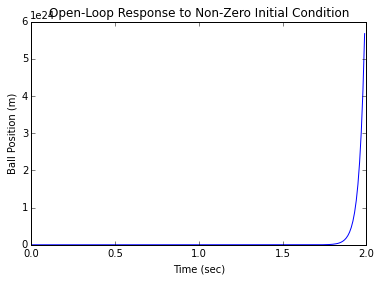

In [18]:
t = np.arange(0, 2, 0.01)
u = zeros(size(t))
x0 = np.array([0.01, 0, 0])
sys = ss(A, B, C, 0)
[y, t, x] = lsim(sys, u, t, x0)
plot(t, y)
title("Open-Loop Response to Non-Zero Initial Condition")
xlabel("Time (sec)")
ylabel("Ball Position (m)")


It looks like the distance between the ball and the electromagnet will go to infinity, but probably the ball hits the table or the floor first (and also probably goes out of the range where our linearization is valid).

## Controllability and Observability

A system is **controllable** if there exists a control input, u(t), that transfers any state of the system to zero in finite time.  It can be shown that an LTI system is controllable if and only if its controllabilty matrix, CO, has full rank (i.e. if rank(CO) = n where n is the number of states ). The rank of the controllability matrix of an LTI model can be determined using the commands ```numpy.linalg.matrix_rank(ctrb(A,B))``` or ```numpy.linalg.matrix_rank(ctrb(sys))```.

$$
CO = [B | AB | A^2B | ... | A^{n-1}B];
$$

All the state variables of a system may not be directly measurable, for instance if the component is in an inaccessible location. In these cases it is neccesary to **estimate** the values of the unknown internal state variables using only the available system outputs.  A system is **observable** if the initial state, x(t_0), can be determined from the system output, y(t), over some finite time t_0 < t < t_f. For LTI systems, the system is observable if and only if the observability matrix, OB, has full rank (i.e. if rank(OB) = n where n is the number of states). The observability of an LTI model can be determined using the command ```rank(obsv(A,C))``` or ```rank(obsv(sys))```.

$$
OB = \left[ \begin{array}{c} C \\ CA \\ CA^2 \\ \vdots \\ CA^{n-1} \end{array} \right]
$$

Controllability and observability are **dual** concepts.  A system (A,B) is controllable if and only if a system (A',C,B',D) is observable. This fact will be useful when designing an observer, as we shall see below.

## Control Design Using Pole Placement

Let's build a controller for this system using pole placement.  The schematic of a full-state feedback system is shown below.  By full-state, we mean that all state variables are known to the controller at all times.  For instance in this system, we would need a sensor measuring the ball position, another measuring velocity, and a third measuring current in the electro-magnet.
![StateSpaceTutorial_ControlDesign_BlockDiagram.png](figures/StateSpaceTutorial_ControlDesign_BlockDiagram.png)
For simplicity, let's assume the reference is zero, R=0.  The input is then:

$$
u = -Kx
$$

The state-space equations for the closed-loop feedback system are therefore:

$$
\dot{x} = (A-BK)x
$$

$$
y = (C-DK)x
$$

The stability and time domain performance of the closed-loop feedback system are determined primarily by the location of the poles (eigenvalues) of the matrix (A-BK).  Since the matrices A and B\*K are both 3 by 3 matrices, there will be 3 poles for the system. By choosing an appropriate K matrix we can place these closed-loop poles anywhere we want. We can use the function ```place``` to find the control matrix, K, which will give the desired poles. Before attempting this method, we have to decide where we want the closed-loop poles to be. Suppose the criteria for the controller were settling time < 0.5 sec and overshoot < 5%, then we might try to place the two dominant poles at -10 +/- 10i (at |zeta| = 0.7 or 45 degrees with |sigma| = 10 > 4.6\*2).  The third pole we might place at -50 to start, and we can change it later depending on what the closed-loop behavior is.

In [27]:
p1 = -10 + 10j
p2 = -10 - 10j
p3 = -50
K = place(A, B, [p1, p2, p3])
sys_cl = ss(A - B * K, B, C, 0)
[y, t, x] = lsim(sys, u, t, x0)
plot(t, y)
xlabel("Time (sec)")
ylabel("Ball Position (m)")


ControlSlycot: can't find slycot module 'sb01bd'

The overshoot is too large (there are also zeros in the transfer function which can increase the overshoot; you do not see the zeros in the state-space formulation).  Try placing the poles further to the left to see if the transient response improves (this should also make the response faster).

In [6]:
p1 = -20 + 20j
p2 = -20 - 20j
p3 = -100
K = place(A,B,[p1 p2 p3])
sys_cl = ss(A-B*K,B,C,0)
[y,t,x] = lsim(sys,u,t,x0)
plot(t, y)
xlabel('Time (sec)')
ylabel('Ball Position (m)')

This time the overshoot is smaller.  Consult your textbook for further suggestions on choosing the desired closed-loop poles. Compare the control effort required (K) in both cases.  In general, the farther you move the poles, the more control effort it takes.

## Introducing the Reference Input

Now, we will take the control system as defined above and apply a step input (we choose a small value for the step, so we remain in the region where our linearization is valid).

In [31]:
t = np.arange(0, 2, 0.01)
u = 0.001 * ones(size(t))
sys_cl = ss(A - B * K, B, C, 0)
# lsim(sys_cl,u,t);
# xlabel('Time (sec)')
# ylabel('Ball Position (m)')
# axis([0 2 -4E-6 0])


ControlSlycot: can't find slycot module 'sb01bd'

The system does not track the step well at all; not only is the magnitude not one, but it is negative instead of positive! Recall the schematic above, we don't compare the output to the reference; instead we measure all the states, multiply by the gain vector K, and then subtract this result from the reference.  There is no reason to expect that K*x will be equal to the desired output.  To eliminate this problem, we can scale the reference input to make it equal to K*x steadystate.  This scale factor is often called |Nbar|; it is introduced as shown in the following schematic:
![StateSpaceTutorial_ReferenceInput_BlockDiagram.png](figures/StateSpaceTutorial_ReferenceInput_BlockDiagram.png)
We can get Nbar from MATLAB by using the function |rscale| (place the following line of code after |K| = ...).

In [8]:
# Nbar = rscale(sys,K)


Note that this function is not standard in MATLAB.  You will need download it here, <Content/Introduction/Control/StateSpace/rscale.m rscale.m>, and save it to your current workspace. Now, if we want to find the response of the system under state feedback with this introduction of the reference, we simply note the fact that the input is multiplied by this new factor, |Nbar|:

In [9]:
# lsim(sys_cl,Nbar*u,t)
# title('Linear Simulation Results (with Nbar)')
# xlabel('Time (sec)')
# ylabel('Ball Position (m)')
# axis([0 2 0 1.2*10^-3])


and now a step can be tracked reasonably well.

## Observer Design

When we can't measure all the states |x| (often the case in practice), we can build an **observer** to estimate them, while measuring only the output |y = C x|.  For the magnetic ball example, we will add three new, estimated states to the system.  The schematic is as follows:
![StateSpaceTutorial_ObserverDesign_BlockDiagram.png](figures/StateSpaceTutorial_ObserverDesign_BlockDiagram.png)
The observer is basically a copy of the plant; it has the same input and almost the same differential equation.  An extra term compares the actual measured output |y| to the estimated output y_hat; this will cause the estimated states \hat{x} to approach the values of the actual states |x|. The error dynamics of the observer are given by the poles of (A-LC). First, we need to choose the observer gain L.  Since we want the dynamics of the observer to be much faster than the system itself, we need to place the poles at least five times farther to the left than the dominant poles of the system.  If we want to use |place|, we need to put the three observer poles at different locations.

In [10]:
# op1 = -100;
# op2 = -101;
# op3 = -102;


Because of the duality between controllability and observability, we can use the same technique used to find the control matrix, but replacing the matrix B by the matrix C and taking the transposes of each matrix

In [11]:
# L = place(A',C',[op1 op2 op3])';


The equations in the block diagram above are given for \hat{x}.  It is conventional to write the combined equations for the system plus observer using the original state |x| plus the error state: |e = x - \hat{x}|.  We use as state feedback |u = -K \hat{x}|.  After a little bit of algebra (consult your textbook for more details), we arrive at the combined state and error equations with the full-state feedback and an observer.

In [12]:
At = numpy.array([[A - B * K, B * K, zeros(size(A)), A - L * C]])
Bt = numpy.array([[B * Nbar, zeros(size(B))]])
Ct = numpy.array([[C, zeros(size(C))]])
# At = [ A-B*K             B*K
#        zeros(size(A))    A-L*C ];
# Bt = [    B*Nbar
#        zeros(size(B)) ];
# Ct = [ C    zeros(size(C)) ];


NameError: name 'A' is not defined

To see how the response looks to a nonzero initial condition with no reference input, add the following lines into your |m-file|. We typically assume that the observer begins with zero initial condition, \hat{x} = 0. This gives us that the initial condition for the error is equal to the initial condition of the state.

In [13]:
# sys = ss(At,Bt,Ct,0);
# lsim(sys,zeros(size(t)),t,[x0 x0]);
# title('Linear Simulation Results (with observer)')
# xlabel('Time (sec)')
# ylabel('Ball Position (m)')


Responses of all the states are plotted below.  Recall that |lsim| gives us |x| and |e|; to get |\hat{x}|, we need to compute |x - e|.

In [14]:
x0 = numpy.array([[0.01, 0.5, -5]])
# t = 0:1E-6:0.1;
# x0 = [0.01 0.5 -5];
# [y,t,x] = lsim(sys,zeros(size(t)),t,[x0 x0]);
# n = 3;
# e = x(:,n+1:end);
# x = x(:,1:n);
# x_est = x - e;


Save state variables explicitly to aid in plotting

In [15]:
# h = x(:,1); h_dot = x(:,2); i = x(:,3);
# h_est = x_est(:,1); h_dot_est = x_est(:,2); i_est = x_est(:,3);
# plot(t,h,'-r',t,h_est,':r',t,h_dot,'-b',t,h_dot_est,':b',t,i,'-g',t,i_est,':g')
# xlabel('Time (sec)')


In [16]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>